In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
import cv2

In [2]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [3]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [4]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [5]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [6]:
combined_data.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [7]:
combined_data['diagnosis'].value_counts()

,count
diagnosis,
0,1805
2,999
1,370
4,295
3,193


In [8]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

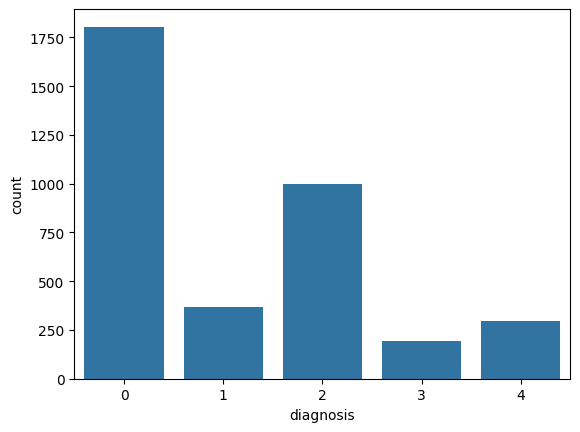

In [9]:
sns.countplot(combined_data,x='diagnosis')

In [10]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [11]:
target_size=500

In [12]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

,id_code,diagnosis
0,ef5155990874,0
1,24de56d433cd,0
2,81914ceb4e74,0
3,a1b28bcbce00,0
4,c365c598ad4e,0


In [13]:
downsampled_df['diagnosis'].value_counts()

,count
diagnosis,
0,500
2,500
1,370
4,295
3,193


In [14]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [15]:
path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [16]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [17]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


<Axes: xlabel='diagnosis', ylabel='count'>

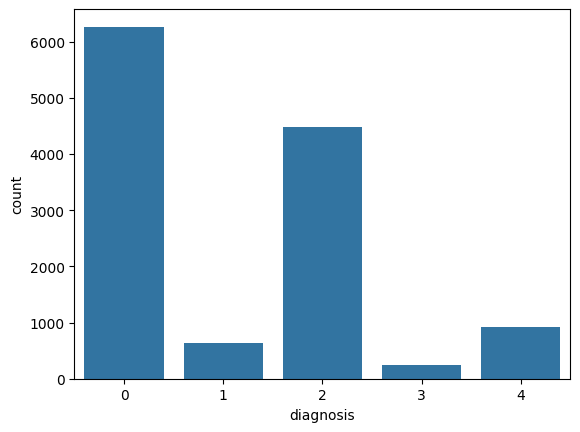

In [18]:
sns.countplot(x='diagnosis',data=labels_df)

In [19]:
labels_df['diagnosis'].value_counts()

,count
diagnosis,
0,6266
2,4477
4,913
1,630
3,236


In [20]:
size=800

In [21]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [22]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

,id_code,diagnosis
0,20170220085833145.jpg,0
1,20170329074906288.jpg,0
2,007-1981-100.jpg,0
3,007-0795-000.jpg,0
4,20170226223624346.jpg,0


In [23]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

In [24]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [25]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [27]:
train_df['diagnosis'].value_counts()

,count
diagnosis,
1,640
0,640
2,640
4,640
3,342


<Axes: xlabel='diagnosis', ylabel='count'>

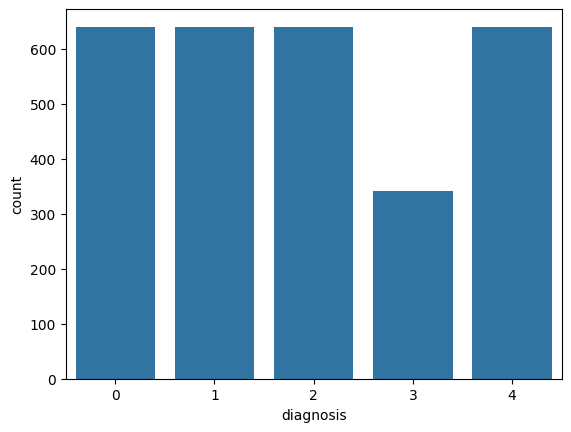

In [29]:
sns.countplot(x='diagnosis',data=train_df)

In [30]:
test_df['diagnosis'].value_counts()

,count
diagnosis,
0,80
1,80
2,80
4,80
3,44


In [31]:
val_df['diagnosis'].value_counts()

,count
diagnosis,
0,80
1,80
2,80
4,80
3,43
